# PyTorch custom dataset 

## Import PyTorch and setup device agnostic code

In [250]:
import torch
from torch import nn

torch.__version__

'2.6.0+cu126'

In [251]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Get Data

In [252]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory already exists, skipping download")
else:
    print(f"{image_path} directory not found, creating one")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak and sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip")
    f.write(request.content)

# Unzip pizza steak sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping the data")
    zip_ref.extractall(image_path)

data\pizza_steak_sushi directory already exists, skipping download
Unzipping the data


## Becoming one with the data (Data preparation and exploration)

In [253]:
import os

def walk_through_dir(dir_path):
    """Walks through dir_path returning its contents"""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)}, images in {dirpath}")

In [254]:
walk_through_dir(image_path)

There are 2 directories and 0, images in data\pizza_steak_sushi
There are 3 directories and 0, images in data\pizza_steak_sushi\test
There are 1 directories and 25, images in data\pizza_steak_sushi\test\pizza
There are 0 directories and 1, images in data\pizza_steak_sushi\test\pizza\.ipynb_checkpoints
There are 0 directories and 19, images in data\pizza_steak_sushi\test\steak
There are 0 directories and 31, images in data\pizza_steak_sushi\test\sushi
There are 3 directories and 0, images in data\pizza_steak_sushi\train
There are 0 directories and 78, images in data\pizza_steak_sushi\train\pizza
There are 0 directories and 75, images in data\pizza_steak_sushi\train\steak
There are 0 directories and 72, images in data\pizza_steak_sushi\train\sushi


In [255]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

### Visualizing an image

Random image path is data\pizza_steak_sushi\test\sushi\2394442.jpg
Image class : sushi
Image height: 408
Image width: 512


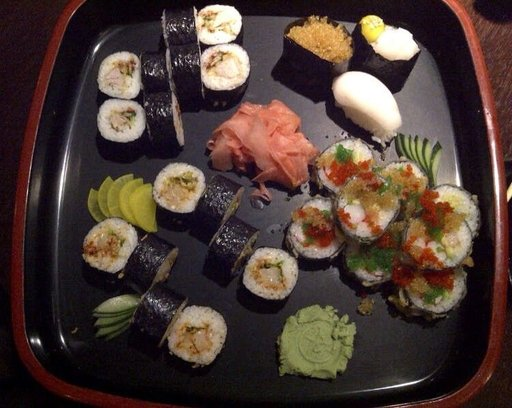

In [256]:
import random
from PIL import Image

# Set seed
random.seed(42)

# Let's get all the image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Pick a rnadom image path
random_image_path = random.choice(image_path_list)

# Get image class from path name (the image class in name of directory where the image is stored)
image_class = random_image_path.parent.stem

# Open image 
img = Image.open(random_image_path)

# Print metadata 
print(f"Random image path is {random_image_path}")
print(f"Image class : {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")

img

(-0.5, 511.5, 407.5, -0.5)

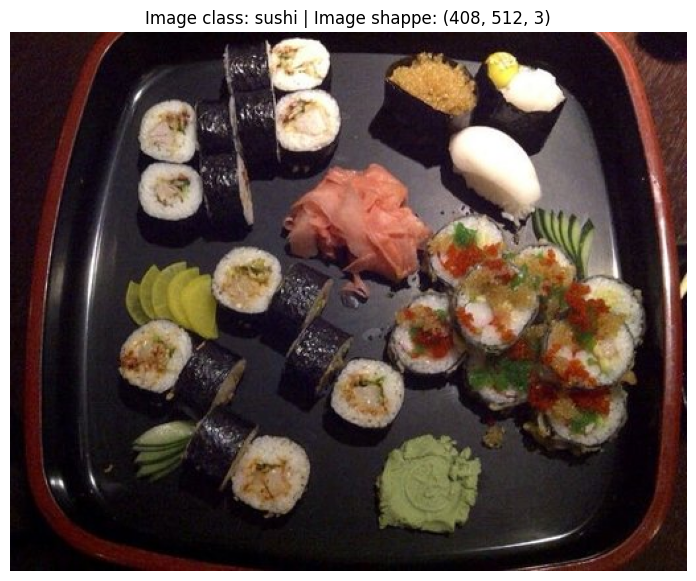

In [257]:
# Try to visualize the image with matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into and array
image_as_array = np.asarray(img)

# PLot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(image_as_array)
plt.title(f"Image class: {image_class} | Image shappe: {image_as_array.shape}")
plt.axis("off")

In [258]:
image_as_array

array([[[33, 13, 15],
        [30, 10, 12],
        [30, 10, 12],
        ...,
        [23, 14, 19],
        [21, 12, 17],
        [20, 11, 16]],

       [[35, 15, 17],
        [32, 12, 14],
        [31, 11, 13],
        ...,
        [21, 12, 17],
        [19, 10, 15],
        [19, 10, 15]],

       [[34, 15, 17],
        [31, 12, 14],
        [30, 11, 13],
        ...,
        [19,  9, 17],
        [18,  8, 16],
        [18,  8, 16]],

       ...,

       [[11,  6, 12],
        [11,  6, 12],
        [11,  6, 12],
        ...,
        [33, 19, 18],
        [33, 19, 19],
        [31, 17, 17]],

       [[ 8,  3,  9],
        [ 9,  4, 10],
        [ 9,  4, 10],
        ...,
        [36, 21, 18],
        [32, 16, 16],
        [27, 11, 11]],

       [[ 4,  0,  5],
        [ 5,  0,  6],
        [ 6,  1,  7],
        ...,
        [36, 21, 18],
        [32, 16, 16],
        [25,  9,  9]]], dtype=uint8)

## Transforming data

- Turn the data into tensors
- Turn it into a `torch.utils.data.Dataset` and subsequently `torch.utils.data.Dataloader`

In [259]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## Transfoming data with torchvision.transforms

In [260]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    #Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [261]:
data_transform(img).shape

torch.Size([3, 64, 64])

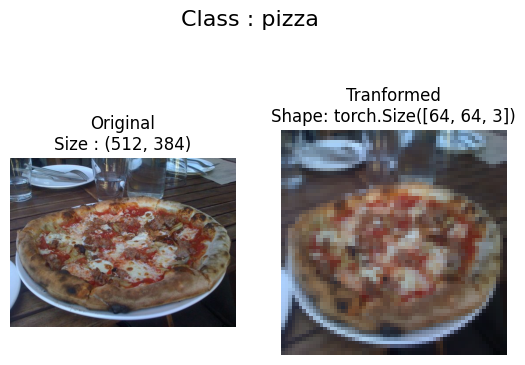

In [262]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """
    Selects random images from a path of images and then plots the 
    original vs tranformed version.
    """
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize : {f.size}")
            ax[0].axis("off")

            # Transform and plot target image
            transformed_image = transform(f).permute(1, 2, 0) # (C, H, W) -> (H, W, C)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Tranformed\nShape: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class : {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                       transform=data_transform,
                       n=3,
                       seed=42)

## Option 1: Loading image data using `ImageFolder`

In [263]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                 transform=data_transform, # transform for the data
                                 target_transform=None) # transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 76
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [264]:
# Class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [265]:
# Class names as dictionary
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [266]:
# Check the lengths of our dataset
len(train_data), len(test_data)

(225, 76)

In [267]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

torch.Size([64, 64, 3]) torch.Size([3, 64, 64])


Text(0.5, 1.0, 'pizza')

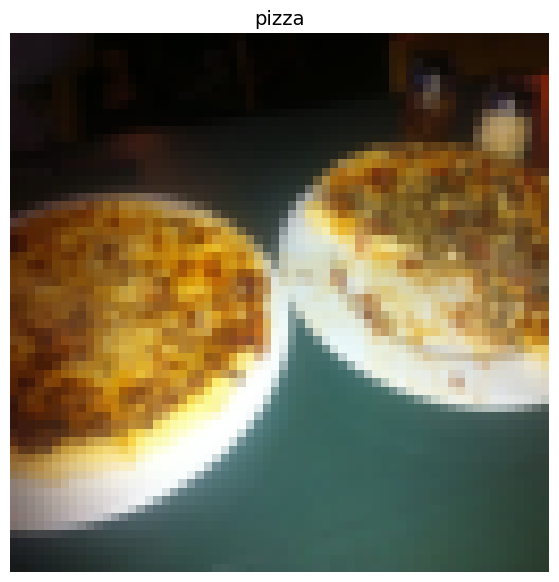

In [268]:
# Rearrange the order of dimensions, because numpy likes color channels at the end
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(img_permute.shape, img.shape)

plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

## Turn loaded images into `DataLoaders`

A `DataLoader` is going to help us turn our `Dataset` into iterables and we can customize batch_size so our model can see batch_size images at a time.

In [269]:
import os
os.cpu_count()

16

In [270]:
from torch.utils.data import DataLoader

BATCH_SIZE=32

train_dataloader = DataLoader(dataset=train_data,
                             batch_size=BATCH_SIZE,
                             # num_workers=os.cpu_count(),
                              num_workers=1,
                             shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                            batch_size=BATCH_SIZE,
                            # num_workers=os.cpu_count(),
                             num_workers=1,
                            shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1bd02ba3b80>,
 <torch.utils.data.dataloader.DataLoader at 0x1bd0286fca0>)

In [271]:
len(train_dataloader), len(test_dataloader)

(8, 3)

In [272]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, you can change the batch size if you like
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


## Loading image data with a custom `Dataset`

- Want to be able to load images from file
- Want to be able to get class names from Dataset
- want to be able to get classes as dictionary

In [273]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [274]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Creating a helper function to get class names

In [275]:
# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data\pizza_steak_sushi\train


['pizza', 'steak', 'sushi']

In [276]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """
    Find the class folder names in a target directory.
    """

    # Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # Raise an error if class names could not be found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure")

    # Cretae a dictionary of index labels(computer prefers numbers than string labels)
    class_to_idx = {class_name : i for i , class_name in enumerate(classes)}
    return classes, class_to_idx

In [277]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Create a custom `Dataset` to replicate `ImageFolder`

In [278]:
# Write a custom dataset class
from torch.utils.data import Dataset

# Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    # Initialize our custom dataset
    def __init__(self, 
                 targ_dir: str, 
                 transform=None):
        # Create class attributes
        # Get all of the image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # Create a function to load images
    def load_image(self, index: int) -> Image.Image:
        """Opens image via a path and returns it"""
        image_path = self.paths[index]
        return Image.open(image_path)

    # Overwrite the __len__()
    def __len__(self) -> int:
        """Returns the total number of samples"""
        return len(self.paths)

    # Overwrite __getitem__() method to return a particular sample
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        """Returns one sample of data, data and label (X, y)."""
        img = self.load_image(index)
        class_name = self.paths[index].parent.name # Expects path in format: data_folder/class_name/image.jpg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return untransformed data and label

In [279]:
# Create a transform
from torchvision import transforms

train_tranforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [280]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                     transform=train_tranforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                    transform=test_transforms)

In [281]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x1bd02bb6740>,
 <__main__.ImageFolderCustom at 0x1bd02bb6320>)

In [282]:
len(train_data), len(train_data_custom)

(225, 225)

In [283]:
train_data_custom.classes, train_data_custom.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [284]:
# Check for equality between original ImageFOlder Dataset and IMageFolderCustomDataset

print(train_data_custom.classes == train_data.classes)
print(test_data_custom.classes == test_data.classes)

True
True


## Create a function to display random images

- Take in a `Dataset` and a number of parameters such as class names and how many images to visualize.
- Cap the images to see at 10 to prevent things getting out of hand.
- Set the random seed.
- Get a list of random sample indexes from dataset.
- Setup matplotlib plot.
- Loop through the random sample images and plot them using matplotlib.

In [285]:
# Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                         classes: List[str] = None,
                         n: int = 10,
                         display_shape: bool = True,
                         seed: int = None):
    # Adjust display if n is too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display, purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # Set the seed
    if seed:
        random.seed(seed)

    # Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # Setup plot
    plt.figure(figsize=(16, 8))
    
    # Loop through random indexes and plot them with matplotlib
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # Adjust tensor dimesions for plotting
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")

        if classes:
            title = f"Class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

In [286]:
# Display random images from the ImageFolder created dataset
display_random_images(train_data,
                     n=5,
                     classes=class_names,
                     seed=None)

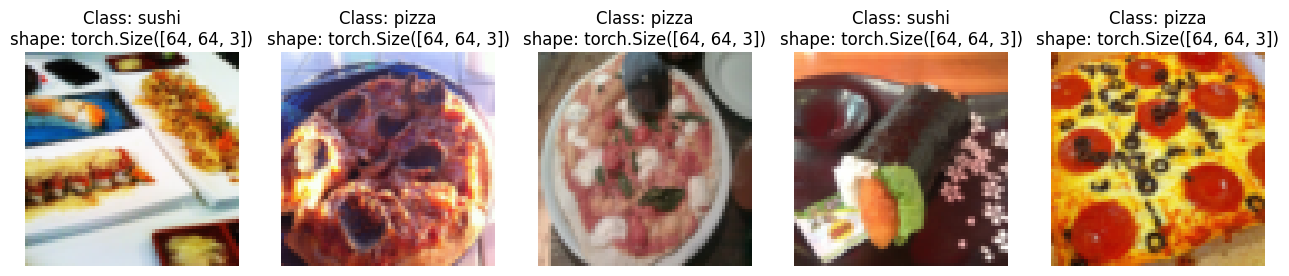

In [287]:
# Display random image from the ImageFolderCustom Dataset
display_random_images(train_data_custom,
                     n=5,
                     classes=class_names,
                     seed=42)

### Turn custom loaded images into DataLoader's

In [288]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=0,
                                    shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                   batch_size=BATCH_SIZE,
                                   num_workers=0,
                                   shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x1bd02b2d120>,
 <torch.utils.data.dataloader.DataLoader at 0x1bd02b2f9a0>)

In [289]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## Other forms of trnasforms (data augmentation)

Data augmentation is process of artificially adding diversity to your training data.

In [290]:
# Let's look at the trivial augment
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

In [291]:
image_path

WindowsPath('data/pizza_steak_sushi')

In [292]:
# Get all image paths

image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[WindowsPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/194643.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/195160.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2003290.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2019408.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2111981.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2124579.jpg')]

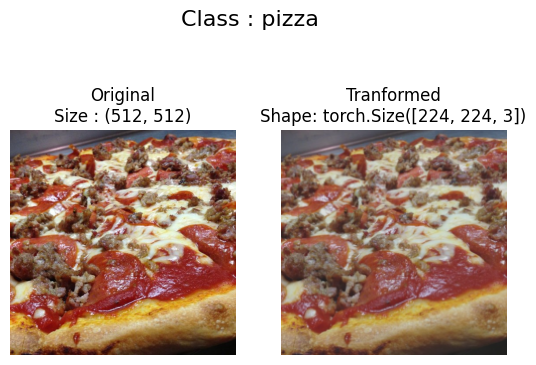

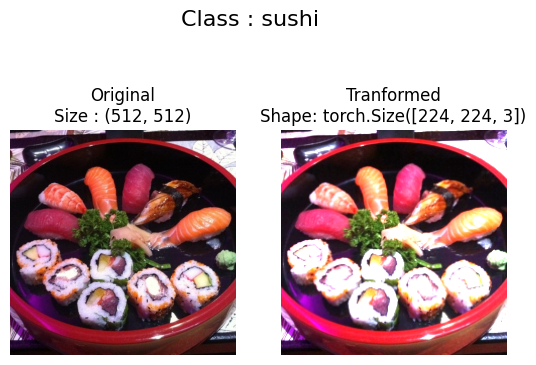

In [293]:
# PLot random trnsformed images
plot_transformed_images(image_paths=image_path_list,
                       transform=train_transform,
                        n=3,
                        seed=None
                       )

## Model 0: TinyVGG without data augmentation

### Creating transforms and loading data for model 0

In [294]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [295]:
# Load and transform data
from torchvision import datasets

train_data_simple = datasets.ImageFolder(root=train_dir,
                                        transform=simple_transform)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                       transform=simple_transform)

# Turn datasets into data loaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create DataLoader's
train_dataloader_simple = DataLoader(
    dataset=train_data_simple,
    batch_size=BATCH_SIZE,
    shuffle=True,
    # num_workers=NUM_WORKERS
)

test_dataloader_simple = DataLoader(
    dataset=test_data_simple,
    batch_size=BATCH_SIZE,
    shuffle=False,
    # num_workers=NUM_WORKERS
)

### Create TInyVGG model class

In [296]:
class TinyVGG(nn.Module):
    """
    Model TinyVGG copied from CNN explainer
    """
    def __init__(self, input_shape: int,
                hidden_units: int,
                output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                     out_channels=hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                     out_channels=hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                        stride=2) # default stride is same as kernel size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                     out_channels=hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                     out_channels=hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                        stride=2) # default stride is same as kernel size
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*13*13,
                     out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

In [297]:
torch.manual_seed(42)

model_0 = TinyVGG(input_shape=3,
                 hidden_units=10,
                 output_shape=len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

## Try a forward pass on a single image

In [298]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))

image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [299]:
# Try a forward pass
model_0(image_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4669e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9129e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0047e-03],
        [ 2.0996e-02,  1.6416e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7226e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3994e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1470e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.2689e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

### Use `torchinfo` to get an idea of the shapes going through our model

In [300]:
import torchinfo
from torchinfo import summary

torchinfo.__version__

'1.8.0'

In [301]:
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

## Create train and test loops functions

- `train_step()` - takes in model and dataloader and trains the model on the dataloader
- `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader

In [302]:
# Create train_step()
def train_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              device=device):
    # Put the model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loade data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to the target device
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X)

        # Calculate the loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Optimizer zero grad
        optimizer.zero_grad()

        # Loss backward
        loss.backward()

        # Optimizer step
        optimizer.step()

        # calculate the accuracy metric
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class==y).sum().item()/len(y_pred)

    # Adjust metrics to get the average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [303]:
# Create a test step
def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device=device):

    # Put the model in eval mode
    model.eval()

    # Setup test loss and test accuracy
    test_loss, test_acc = 0, 0

    # Turn on inference mode
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # Forward pass
            test_pred_logits = model(X)

            # calculate the loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # calculate the accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels==y).sum().item()/len(test_pred_labels))

        # Adjust metrics to get average loss and accuracy per batch
        test_loss = test_loss / len(dataloader)
        test_acc = test_acc / len(dataloader)
        return test_loss, test_acc

## Creating a `train()` function to combine `train_step()` and `test_step()`

In [304]:
from tqdm.auto import tqdm

# Create a train function that takes in various model parameters
def train(model: torch.nn.Module,
         train_dataloader: torch.utils.data.DataLoader,
         test_dataloader: torch.utils.data.DataLoader,
         optimizer: torch.optim.Optimizer,
         loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
         epochs: int = 5,
         device=device):
    # Create a empty results dictionary
    results = {"train_loss" : [],
              "train_acc": [],
              "test_loss": [],
              "test_acc": []}

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
                                       dataloader=test_dataloader,
                                       loss_fn=loss_fn,
                                       device=device)

        # Print out what is happening
        print(f"Epoch: {epoch} | Train loss: {train_loss:.4f}, Train acc: {test_acc: .4f} | Test loss : {test_loss:.4f}, Test acc: {test_acc:.4f}")

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

### Train and evaluate mode 0

In [305]:
# Set the random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3,
                 hidden_units=10,
                 output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                            lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train_model_0
model_0_results = train(model=model_0,
                       train_dataloader=train_dataloader_simple,
                       test_dataloader=test_dataloader_simple,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=NUM_EPOCHS)

# End the timer and print out time
end_time = timer()

print(f"Total training time : {end_time-start_time: .3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1063, Train acc:  0.2986 | Test loss : 1.0984, Test acc: 0.2986
Epoch: 1 | Train loss: 1.0998, Train acc:  0.5312 | Test loss : 1.0712, Test acc: 0.5312
Epoch: 2 | Train loss: 1.0869, Train acc:  0.4722 | Test loss : 1.0827, Test acc: 0.4722
Epoch: 3 | Train loss: 1.0843, Train acc:  0.5556 | Test loss : 1.0631, Test acc: 0.5556
Epoch: 4 | Train loss: 1.0663, Train acc:  0.5417 | Test loss : 1.0676, Test acc: 0.5417
Total training time :  4.479 seconds


In [306]:
model_0_results

{'train_loss': [1.1063192039728165,
  1.099796861410141,
  1.086857795715332,
  1.0843407064676285,
  1.066293016076088],
 'train_acc': [0.3046875, 0.328125, 0.48828125, 0.40234375, 0.4140625],
 'test_loss': [1.098363200823466,
  1.0712297360102336,
  1.0826905171076457,
  1.0631173451741536,
  1.0675526062647502],
 'test_acc': [0.2986111111111111,
  0.53125,
  0.47222222222222215,
  0.5555555555555555,
  0.5416666666666666]}

## Plot the loss curves for model 0

In [307]:
# Gte the model_0 results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [308]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """
    Plot training curves of a results dictionary
    """
    # Get the loss calues of results dictionary (training and test)
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    # Get accuracy values of the results dictionary
    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    # Figure out how many epochs were there
    epochs = range(len(results["train_loss"]))

    # Setup plot
    plt.figure(figsize=(15, 7))

    # PLot the loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

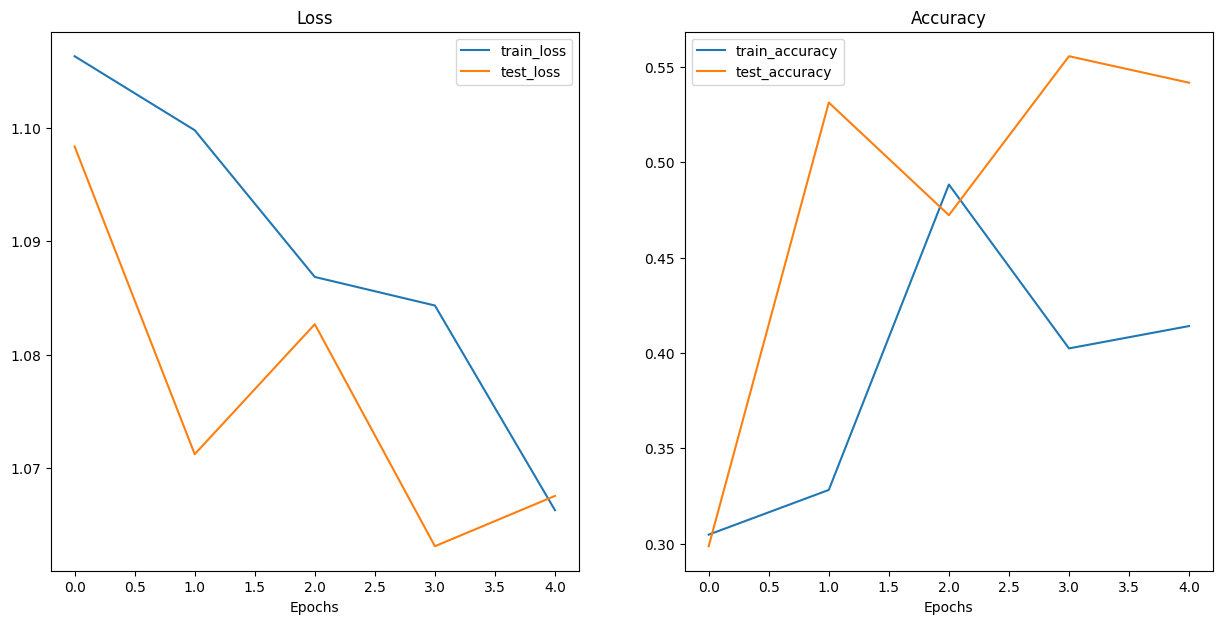

In [309]:
plot_loss_curves(model_0_results)

## TinyVGG with data augmentation

In [310]:
# Create training transform with TrivialAugment
from torchvision import transforms

train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

### Create train and test `Dataset` and `DataLoader` with data augmentation


In [311]:
# Turn image folders into Datasets
from torchvision import datasets

train_data_augmented = datasets.ImageFolder(root=train_dir,
                                           transform=train_transform_trivial)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                          transform=test_transform_simple)

In [312]:
#Turn our datasets into DataLoaders
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                 batch_size=BATCH_SIZE,
                                 shuffle=True,
                                 # num_workers=NUM_WORKERS
                                 )
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                   batch_size=BATCH_SIZE,
                                   shuffle=False,
                                   # num_workers=NUM_WORKERS
                                   )

## Construct and train model 1

We are using the same model but with some augmented data...

In [313]:
# Create model_1 and send it to the target device
torch.manual_seed(42)

model_1 = TinyVGG(input_shape=3,
                 hidden_units=10,
                 output_shape=len(train_data_augmented.classes)).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [314]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                            lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model 1
model_1_results = train(model=model_1,
                       train_dataloader=train_dataloader_augmented,
                       test_dataloader=test_dataloader_simple,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=NUM_EPOCHS,
                       device=device)

# End the timer and check time
end_time = timer()

print(f"Total training time for model_1 : {end_time-start_time: .3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1036, Train acc:  0.2708 | Test loss : 1.1005, Test acc: 0.2708
Epoch: 1 | Train loss: 1.0721, Train acc:  0.2708 | Test loss : 1.1381, Test acc: 0.2708
Epoch: 2 | Train loss: 1.1431, Train acc:  0.2708 | Test loss : 1.1570, Test acc: 0.2708
Epoch: 3 | Train loss: 1.0853, Train acc:  0.2708 | Test loss : 1.1012, Test acc: 0.2708
Epoch: 4 | Train loss: 1.0973, Train acc:  0.2708 | Test loss : 1.0869, Test acc: 0.2708
Total training time for model_1 :  4.753 seconds


### Plot the loss curves of model 1

Lets go visual

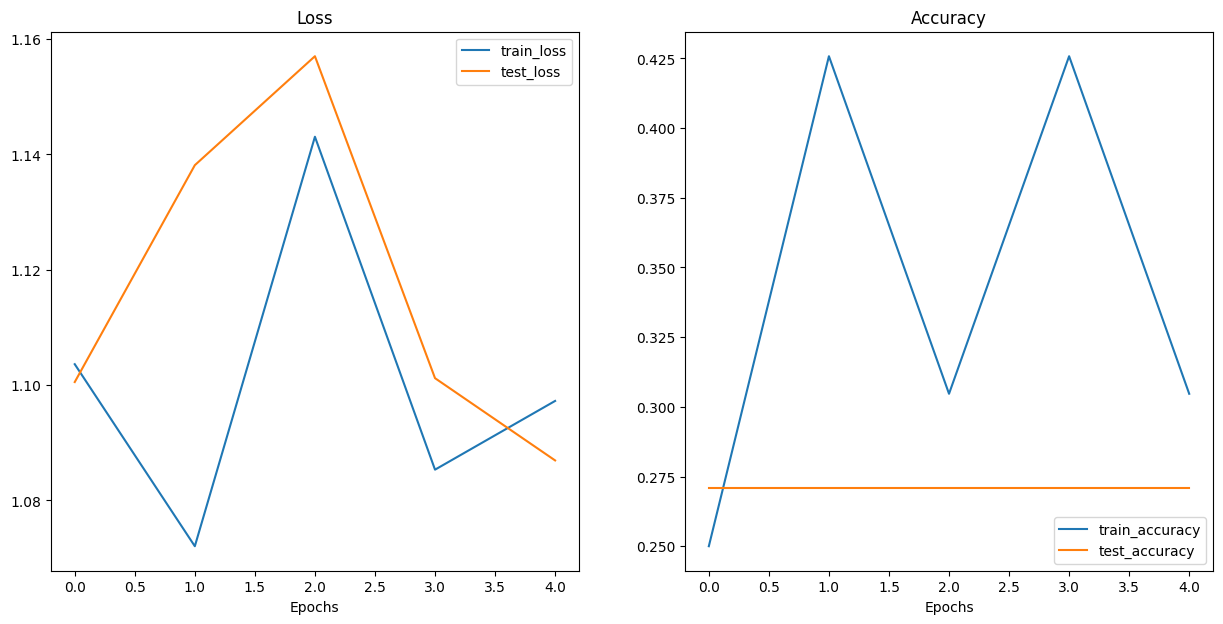

In [315]:
plot_loss_curves(model_1_results)

## Compare model results

After evaluating the models it is better to compare them with each other.

In [316]:
import pandas as pd

model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

train_loss  train_acc  test_loss  test_acc
0    1.106319   0.304688   1.098363  0.298611
1    1.099797   0.328125   1.071230  0.531250
2    1.086858   0.488281   1.082691  0.472222
3    1.084341   0.402344   1.063117  0.555556
4    1.066293   0.414062   1.067553  0.541667

In [317]:
model_1_df

train_loss  train_acc  test_loss  test_acc
0    1.103629   0.250000   1.100532  0.270833
1    1.072068   0.425781   1.138133  0.270833
2    1.143062   0.304688   1.157025  0.270833
3    1.085342   0.425781   1.101204  0.270833
4    1.097258   0.304688   1.086942  0.270833

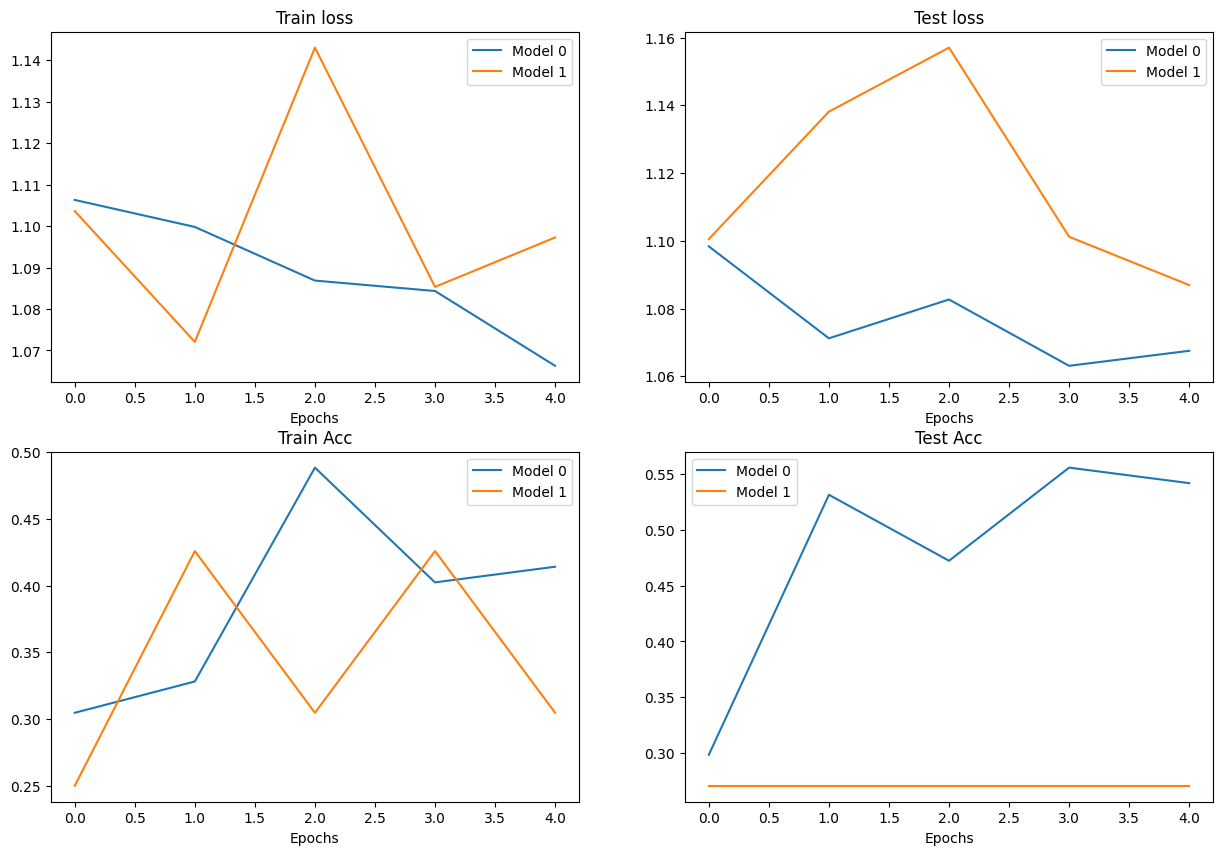

In [325]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train loss")
plt.xlabel("Epochs")
plt.legend()

# plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test loss")
plt.xlabel("Epochs")
plt.legend()

# plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Acc")
plt.xlabel("Epochs")
plt.legend()

# plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Acc")
plt.xlabel("Epochs")
plt.legend()

## Making a prediction on a custom image

How to make a prediction from image that in not in both train and test dataset

In [326]:
# Download a custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exists
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}....")
        f.write(request.content)
else:
    print(f"Custom image path already exists skipping download...")

### Load custom image with PyTorch

Make sure custom image is in same format as data.

- Tensor with data tyoe float32
- shape 64x64x3
- on right device

In [336]:
import torchvision 

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(custom_image_path).type(torch.float32) / 255.
custom_image_uint8

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

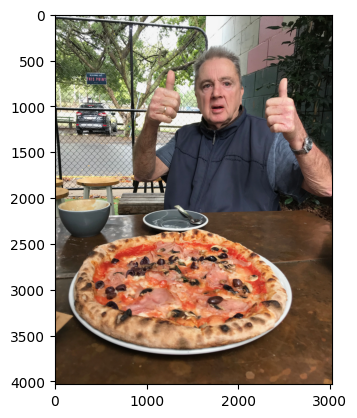

In [337]:
plt.imshow(custom_image_uint8.permute(1,2,0))

In [338]:
print(f"Custom image tensor:\n {custom_image_uint8}")
print(f"Custom image shape: {custom_image_uint8.shape}")
print(f"Custom image datatype: {custom_image_uint8.dtype}")

Custom image tensor:
 tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  .

## Making a prediction on a custom image with a trained pytorch model


In [335]:
# try to make prediction on an image
# model_1.eval()
# with torch.inference_mode():
    # model_1(custom_image_uint8.to(device))

In [341]:
# Create tranform pipeline to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64, 64))
])

custom_image_transformed = custom_image_transform(custom_image_uint8)

custom_image_transformed.shape

torch.Size([3, 64, 64])

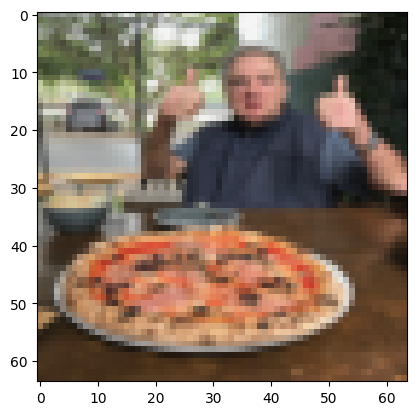

In [342]:
plt.imshow(custom_image_transformed.permute(1, 2, 0))

In [344]:
custom_image_transformed.shape

torch.Size([3, 64, 64])

In [345]:
# Error because no batch size
# model_1.eval()
# with torch.inference_mode():
#     custom_image_pred = model_1(custom_image_transformed.to(device))

In [348]:
custom_image_transformed.unsqueeze(dim=0).shape

torch.Size([1, 3, 64, 64])

In [351]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))

custom_image_pred

tensor([[ 0.0800, -0.1665, -0.0420]], device='cuda:0')

In [357]:
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1).cpu()
custom_image_pred_label

tensor([0])

In [360]:
class_names[custom_image_pred_label]

'pizza'

### Putting custom image prediction togeter: building a function

Ideal outcome:

A function where we pass an image path to have our model predict on that image.

In [361]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                       transform=None,
                       device=device):
    """
    Makes a prediction on a target image with a trained model and plots the image and prediction
    """
    # Load the image
    target_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

    # Divide the image pixel values by 255 to get them in [0, 1]
    target_image = target_image / 255.

    # Transform the data if necessary
    if transform:
        target_image = transform(target_image)

    # Make sure the model in on the target device
    model.to(device)
    
    # Turn on eval/inference mode to make a prediction
    model.eval()
    with torch.inference_mode():
        # add the batch dimension to the single image
        target_image = target_image.unsqueeze(0) 
        
        # make a prediction
        target_image_pred = model(target_image.to(device))

    # convert the logits -> prediction probabilities
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    
    # convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0))
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu(): .3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu(): .3f}"
    plt.title(title)
    plt.axis("off")

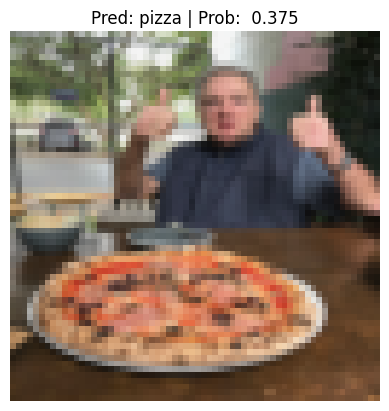

In [362]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                   image_path=custom_image_path,
                   class_names=class_names,
                   transform=custom_image_transform,
                   device=device)